In [1]:
# Binary Selection
import os
import sys

# The working directory if connected over SSH will be the top level of the repository
# Set it manually here
working_directory = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis'
os.chdir(working_directory)


sys.path.append(os.path.join(working_directory, 'utils'))
import AstroPandas as ap


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.io import fits
from astropy.table import Table

import AnalysisFunctions as af
import DataFunctions as df

pd.set_option('display.max_columns', None)

GALAH_data = df.FitsToDF(('/avatar/yanilach/PhD-Home/binaries_galah-main/catalogs/galah_dr4_allspec_240207.fits'))
GALAH_data


traven_file = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis/assets/TravenSample/catalog.dat'
traven_file_readme = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis/assets/TravenSample/ReadMe.txt'

traven_data = pd.read_fwf(traven_file, header=None)
traven_data[0]

0        131116000501103
1        131116000501201
2        131116000501244
3        131116000501259
4        131116000501288
              ...       
12755    180130002801307
12756    180130002801335
12757    180130002801336
12758    180130002801347
12759    180130002801368
Name: 0, Length: 12760, dtype: int64

In [3]:
GALAH_data


# Also useful here are chi2_sp and comp_time

# Select rv_comp_nr from GALAH data where rv_comp_nr > 1
selection1 = GALAH_data['rv_comp_nr'] > 1


# Select for over-luminous stars, which could be indicative of a binary system for a given mass. Assume MS relation.
# selection2 = (GALAH_data['mass'] ** 3.5 > GALAH_data['lbol'] + 1) & (GALAH_data['age'] < 10)

# Select for large differences between the RVs from the GALAH DR3 and Gaia DR3
selection2 = abs(GALAH_data['rv_comp_1'] - GALAH_data['rv_gaia_dr3']) > 20


# Select for higher RUWE values, which can be indicative of a binary system.
# RUWE is the Renormalised Unit Weight Error, which is a measure of the quality of the astrometric solution.
# Note two papers which suggest values of RUWE > 1.4 and RUWE > 1.25 as indicative of a binary system.
# Penoyre et al. (2022a) (DR3 < 100pc) and Lindegren (2018) (DR2)
# Note also: Gaia DR2 ruwe_dr2 > 1.4 is also available in flag_sp = 1
selection3 = GALAH_data['ruwe'] > 1.4 #GALAH_data['ruwe'][selection].median() + (GALAH_data['ruwe'].std() * 2)


# Select for higher rotational velocities due to tidal interactions between stars. 
# Note that high rotational velocities are not necessarily indicative of a binary system are also correlated with hot stars, younger stars (magnetic braking), etc.
selection4 = (GALAH_data['vsini'] > GALAH_data['vsini'][selection1].median()) & (GALAH_data['age'] < 10)


# In some binaries, especially close ones or those with accretion processes, spectral lines like H-alpha and H-beta may show unusual broadening or emission.
# Look for stars with strong or wide H-alpha (ew_h_alpha) and H-beta (ew_h_beta) emission/absorption, which could suggest interaction between binary components.
selection5 = (GALAH_data['ew_h_alpha'] < GALAH_data['ew_h_alpha'][selection1].median()) | (GALAH_data['ew_h_beta'] < GALAH_data['ew_h_beta'][selection1].median())


# Look for stars with large differences between the Gaia EDR3 and GALAH parallaxes.
# Could be due to changes in the poitions of the stars between surveys?
selection6 = (GALAH_data['parallax'] - GALAH_data['parallax_gaia_edr3']).abs() > 0.05


# Get all objects in GALAH data also in Traven data with same sobject_id
selection7 = GALAH_data['sobject_id'].isin(traven_data[0])

# Combine selections statements
full_selection = selection1 | selection2 | selection3 | selection4 | selection5 | selection6 | selection7


# Quality Cuts
cuts = (GALAH_data['teff'] >= 3000) & \
        (GALAH_data['flag_sp'] != 4)  # Low S/N (snr_c2_iraf<10). There are other useful flags in here too. Check the table schema.
    # GALAH_data['snr_DR3'] >= 50 # Temp value This is not in the table but appears in the schema?


GALAH_data[full_selection & cuts]




,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,rv_comp_nr,rv_comp_1,e_rv_comp_1,rv_comp_1_p,rv_comp_2,rv_comp_2_h,rv_comp_2_p,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,logg_spec,e_logg_spec,phot_g_mean_mag,phot_bp_mean_mag,bp_rp,h_m,h_msigcom,ks_m,ks_msigcom,ebv,W2mag,e_W2mag,parallax,e_parallax,parallax_gaia_edr3,e_parallax_gaia_edr3,ruwe,r_med,r_lo,r_hi,a_ks,mass,age,bc_ks,lbol
2,131216001101006,05242175-5855050,4762746688313325568,other,-1,single,56642.574219,81.090652,-58.918076,10240,1,3,0,1.305176,7.568689,19.137445,26.825100,0.870162,94,3600_4.00_-0.25,3800_4.00_-0.50,248.433228,4,22.605518,0.687886,0.149075,-532.0,0.939481,0.073592,22.222137,3.419456,-2.060522,3770.071289,73.860588,4.805919,0.101890,-0.348866,0.085777,0,1.724152,0.309961,10.233937,1.577342,-0.649014,0.556269,64,0.121796,0.078208,32,-0.865735,0.082725,32,-0.383051,0.072100,0,-0.232355,0.081095,0,-0.059094,0.045800,0,0.192743,0.137139,0,0.561816,0.077553,0,0.256668,0.066790,0,-0.294023,0.073045,64,0.526986,0.114278,0,0.434738,0.063186,0,0.586431,0.109639,0,0.321548,0.091762,0,-0.002184,0.216561,0,-0.346132,0.159813,0,-0.496376,0.050111,0,-0.342704,0.179532,0,0.093394,0.258111,0,0.254146,0.277884,0,-0.367177,0.416988,0,0.680049,0.182433,0,0.407173,0.361845,0,-0.049509,0.366830,1,-0.475951,0.438094,1,0.062648,0.119791,64,-0.053936,0.584508,1,0.234395,0.958355,0,-0.493212,0.421430,0,0.243174,0.365216,0,NaN,NaN,2,NaN,-107.394485,NaN,0.332179,0.291729,0.938768,0.640222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015227,0.140289,6.386253,4.213432,0.112906,14.936241,16.037773,2.144983,11.961,0.024,11.716,0.024,0.029000,11.510,0.021,6.528944,0.019247,6.528944,0.019247,1.011173,153.098846,152.701675,153.421875,0.010440,0.485706,2.239814,2.522930,0.037892
8,131216001101014,05242161-5901319,4762739782006427648,other,-1,single,56642.574219,81.090057,-59.025547,32,0,-1,0,21.918205,39.575691,61.636883,59.026356,0.852499,94,5000_4.50_0.00,5000_4.50_0.00,91.954468,1,29.125610,0.236062,0.553842,NaN,NaN,NaN,30.012358,6.786986,-2.058169,5005.102051,71.746521,4.373563,0.107970,0.023206,0.056725,0,1.110965,0.285121,-0.349899,1.519853,-0.354660,0.101081,0,-0.154191,0.066346,32,-0.304398,0.142212,33,-0.475257,0.087448,1,0.159235,0.024486,0,0.088041,0.019588,0,0.173052,0.042133,0,0.147481,0.026749,0,-0.015358,0.039907,0,0.053981,0.035083,0,0.057902,0.034113,0,0.021581,0.028557,0,0.242596,0.028046,0,0.033905,0.020170,0,0.130837,0.032699,0,0.046786,0.045105,0,0.081808,0.018652,0,-0.085545,0.048125,0,0.148046,0.095962,0,0.358326,0.290220,0,0.703718,0.289580,1,0.104994,0.078814,0,0.316808,0.259514,1,NaN,NaN,2,NaN,NaN,2,-0.330089,0.067085,0,0.010886,0.277828,1,-0.285151,0.513218,1,-0.582617,0.241117,1,-0.907513,0.368562,1,NaN,NaN,2,NaN,NaN,NaN,0.104559,0.268784,0.778384,1.030426,NaN,NaN,NaN,0.011338,0.11738

### Fit a simple model to the binary main sequence for testing

            2
-9.863e-08 x + 0.000746 x + 3.024


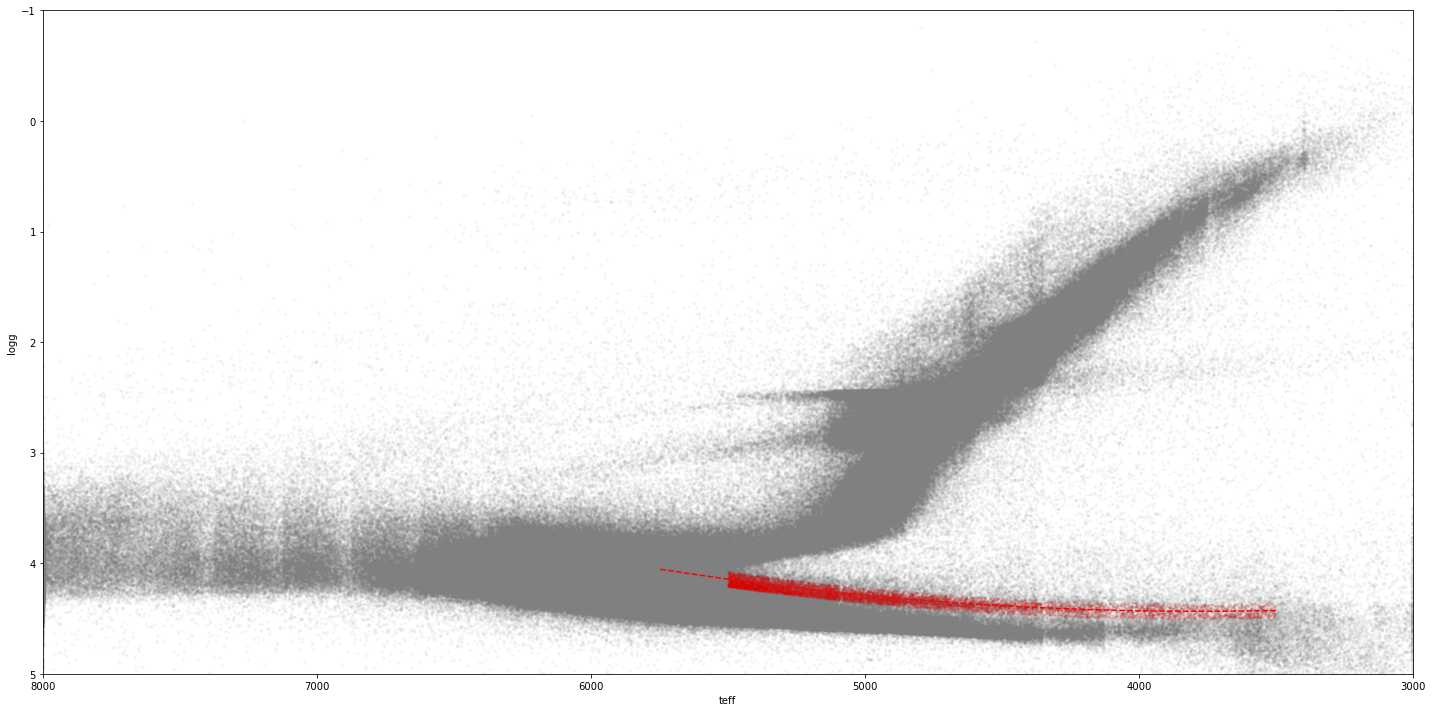

In [7]:

ms_binaries = [(3000, 4.4), (3500, 4.4), (4000, 4.4), (4500, 4.4), (5000, 4.3), (5500, 4.2), (5750, 4)]
min_teff = np.min([x for x, y in ms_binaries])
max_teff = np.max([x for x, y in ms_binaries])

# Polyfit these coordinates
x, y = zip(*ms_binaries)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)
print(polynomial)

plt.figure(figsize=(20, 10))
plt.scatter(GALAH_data['teff'], GALAH_data['logg'], alpha=0.05, label='All', color='gray', s=5)
# Plot the polynomial
plt.plot(np.arange(3500, max_teff), polynomial(np.arange(3500, max_teff)), color='red', label='Main Sequence', ls='--')


# Plot all data points within a short distance of the line
distance = 0.07
ms_binary_selection = (GALAH_data['logg'] < polynomial(GALAH_data['teff']) + distance) & (GALAH_data['logg'] > polynomial(GALAH_data['teff']) - distance)
ms_binary_selection = ms_binary_selection & (GALAH_data['teff'] > 3500) & (GALAH_data['teff'] < 5500)
plt.scatter(GALAH_data['teff'][ms_binary_selection], GALAH_data['logg'][ms_binary_selection], alpha=0.05, label='MS', color='red', s=1)


plt.xlabel('teff')
plt.ylabel('logg' )
plt.ylim(-1, 5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# plt.legend(handles=legend_handles, prop={'size': 22}, loc='upper left')
plt.xlim(8000, 3000)
plt.tight_layout()

plt.show()




In [8]:
"""
Compare the median of all the values in the GALAH data table to the median of the values in the GALAH table for the binary selection only.
See which parameters vary the most.
"""


selection = selection1
pd.set_option('display.max_rows', None)

numerical_cols = GALAH_data.columns[13:-1]
# Exclude cols that contain "model"
numerical_cols = [col for col in numerical_cols if 'model' not in col]
diff_table = pd.DataFrame(columns=['Column'])

for col in numerical_cols:
    # print(GALAH_data[col][~selection].median())
    # print(GALAH_data[col][selection].median())

    # Find the percentage difference between the median value of the column and the median value of the column for the bianry selection.
    # High differences here may be indicative of a binary system.
    if GALAH_data[col][~selection].median() != 0:
        perc_diff = np.round(((GALAH_data[col][selection].median() - GALAH_data[col][~selection].median()) / GALAH_data[col][~selection].median()) * 100, 2)
        perc_diff_ms = np.round(((GALAH_data[col][ms_binary_selection].median() - GALAH_data[col][~ms_binary_selection].median()) / GALAH_data[col][~ms_binary_selection].median()) * 100, 2)
        
        if col == 'cu_fe':
            print(GALAH_data[col][selection].median(), GALAH_data[col][~selection].median())
        

        new_row = pd.DataFrame({'Column': [col], 'Percentage Difference (n_comps > 1)': [abs(perc_diff)], 'Percentage Difference (MS Binaries)': [abs(perc_diff_ms)]})
        diff_table = pd.concat([diff_table, new_row], ignore_index=True)

        

# Add a new col summing the others
# diff_table['Sum'] = diff_table['Percentage Difference (n_comps > 1)'] + diff_table['Percentage Difference (MS Binaries)']
# Add avg col
diff_table['Avg'] = diff_table[['Percentage Difference (n_comps > 1)', 'Percentage Difference (MS Binaries)']].mean(axis=1)
diff_table.sort_values('Avg', ascending=False)

0.06735560297966003 0.0018084794282913208


,Column,Percentage Difference (n_comps > 1),Percentage Difference (MS Binaries),Avg
102,sb2_rv_16,9467.63,400.17,4933.900
64,cu_fe,3624.43,2411.16,3017.795
99,eu_fe,1743.07,1679.82,1711.445
82,ru_fe,355.89,1419.75,887.820
48,ca_fe,468.95,1146.57,807.760
74,y_fe,711.79,716.82,714.305
50,sc_fe,218.07,288.32,253.195
27,li_fe,140.56,337.60,239.080
76,zr_fe,406.78,25.84,216.310
11,rv_comp_2,NaN,200.00,200.000


In [4]:
# # row = 'chi2_sp'

# for row in numerical_cols:
#     row_data_1 = GALAH_data[row]
#     row_data_2 = GALAH_data[row][ms_binary_selection]

#     # Remove outliers
#     row_data_1 = row_data_1[(row_data_1 < row_data_1.quantile(0.95)) & (row_data_1 > row_data_1.quantile(0.05))]
#     row_data_2 = row_data_2[(row_data_2 < row_data_2.quantile(0.95)) & (row_data_2 > row_data_2.quantile(0.05))]

#     plt.figure(figsize=(10, 5))
#     plt.hist(row_data_1, bins=100, density=True)
#     plt.hist(row_data_2, bins=100, density=True, alpha=0.5)
#     plt.axvline(row_data_1.median(), color='blue', ls='--')
#     plt.axvline(row_data_2.median(), color='red', ls='--')
#     plt.title(row)
#     plt.legend(['All', 'MS Binaries'])
#     plt.show()

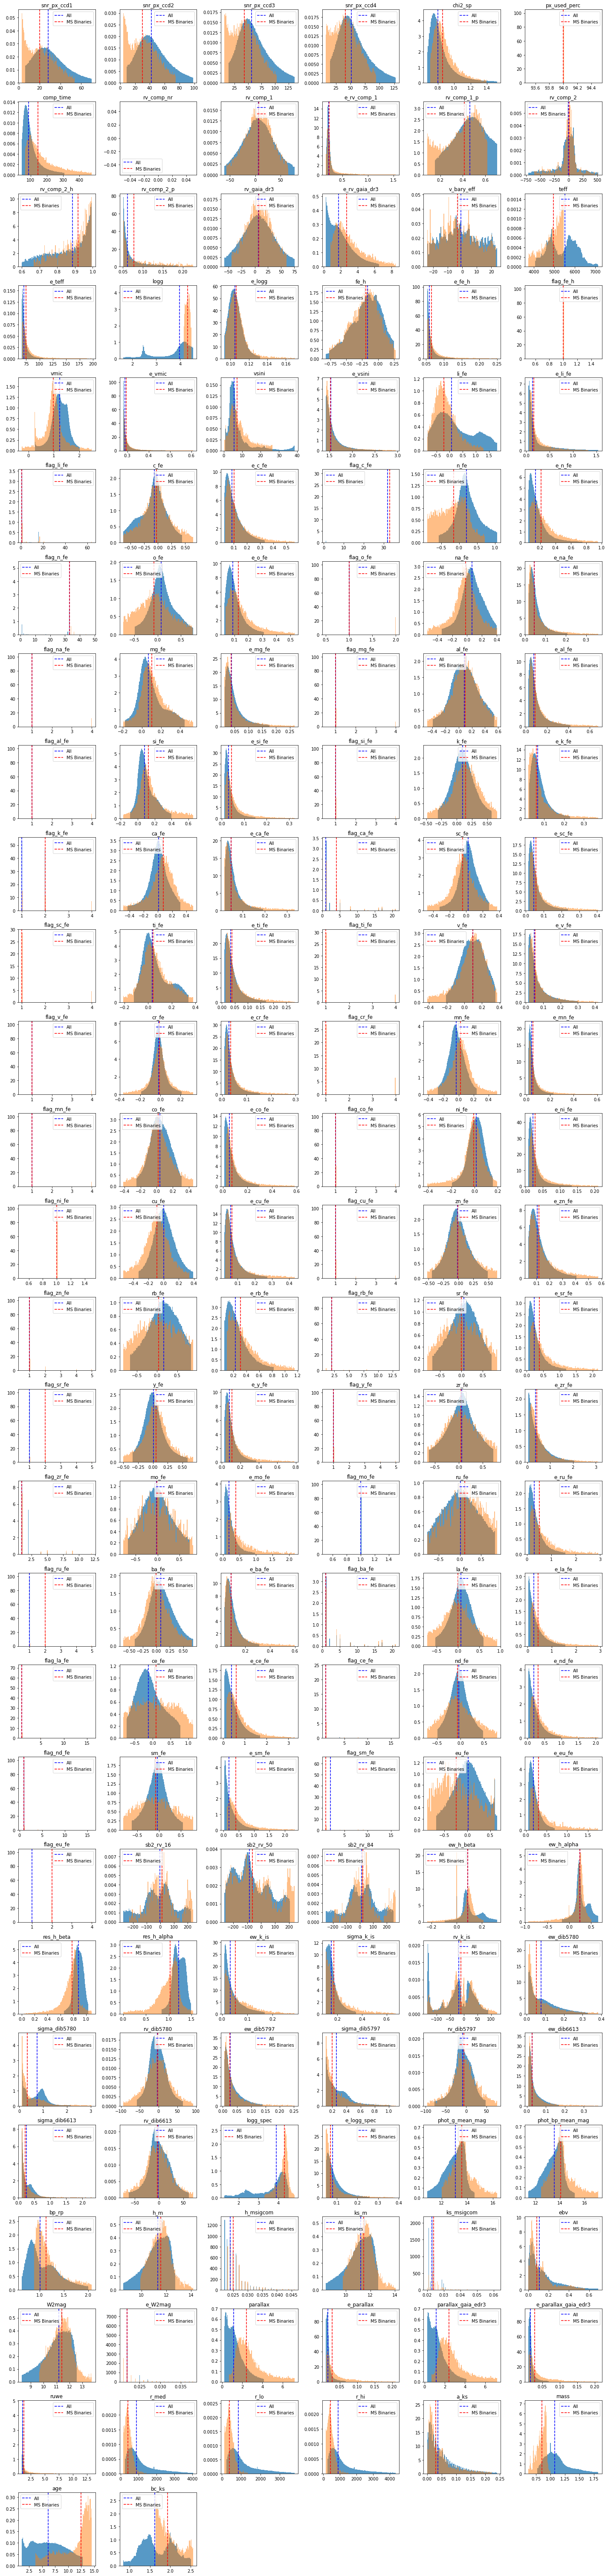

In [523]:
"""
Plot histograms for all paramaters.
"""

# Number of columns and rows
n_cols = 6
n_rows = int(np.ceil(len(numerical_cols) / n_cols))  # Determine the required number of rows

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))  # Adjust figsize as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, row in enumerate(numerical_cols):
    row_data_1 = GALAH_data[row]
    row_data_2 = GALAH_data[row][ms_binary_selection]

    # Remove outliers
    row_data_1 = row_data_1[(row_data_1 < row_data_1.quantile(0.95)) & (row_data_1 > row_data_1.quantile(0.05))]
    row_data_2 = row_data_2[(row_data_2 < row_data_2.quantile(0.95)) & (row_data_2 > row_data_2.quantile(0.05))]

    # Plot the histograms
    axes[i].hist(row_data_1, bins=100, density=True, alpha=0.75)
    axes[i].hist(row_data_2, bins=100, density=True, alpha=0.5)
    
    # Add vertical lines for the medians
    axes[i].axvline(row_data_1.median(), color='blue', ls='--')
    axes[i].axvline(row_data_2.median(), color='red', ls='--')

    # Add title and legend
    axes[i].set_title(row)
    axes[i].legend(['All', 'MS Binaries'])

# Remove empty subplots if the number of numerical_cols is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


##### Try comparing if each star is closer to the average elemental abundance of the binary sample or the complete set.

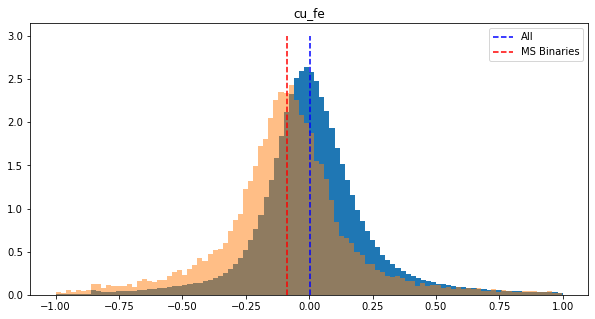

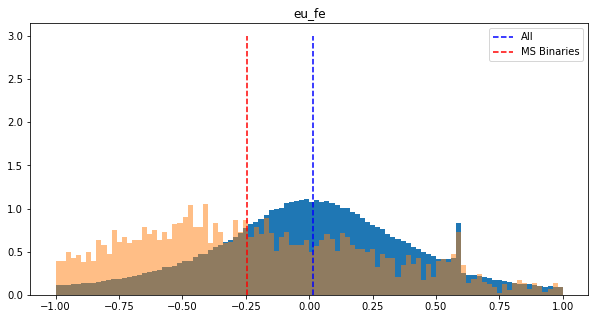

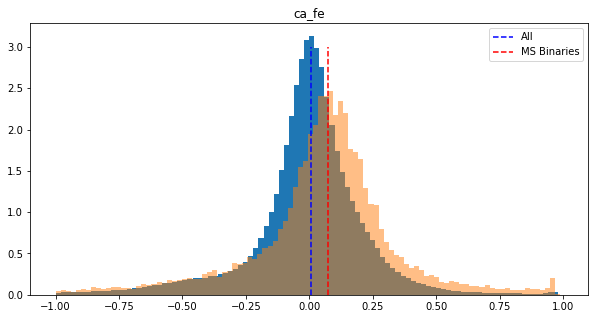

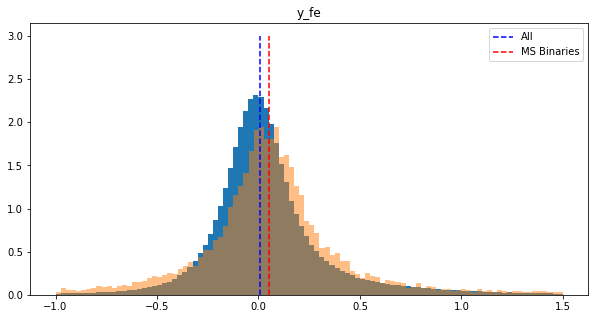

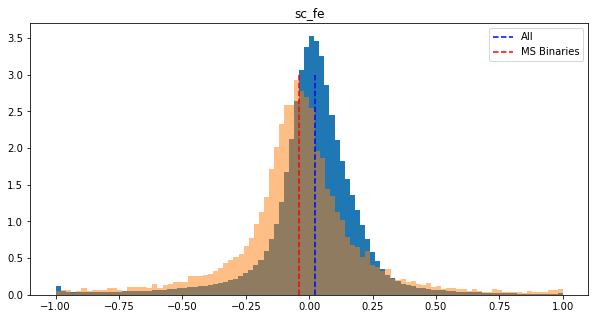

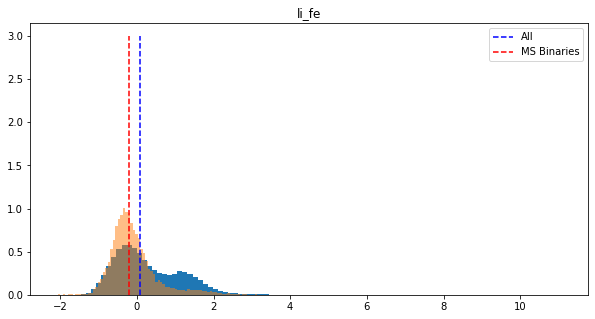

In [505]:
# 0.0018084794282913208

pd.set_option('display.max_rows', 50)

# These elements show the highest difference between the median values of the binary and non-binary selections.
elements = ['cu_fe', 'eu_fe', 'ca_fe', 'y_fe', 'sc_fe', 'li_fe']


# mask = abs((GALAH_data['cu_fe'] - GALAH_data['cu_fe'].median()) / GALAH_data['cu_fe'].median() * 100) > 400
# Select all rows where cu_fe is more than 400% different from the median
mask = abs((GALAH_data['cu_fe'] - GALAH_data['cu_fe'][~ms_binary_selection].median())) > 0

# plt.figure(figsize=(10, 5))
# # plt.hist(new_df['percentage_diff'][~ms_binary_selection], bins=1000, density=True)
# # plt.hist(new_df['percentage_diff'][ms_binary_selection], bins=1000, density=True)
# plt.hist(GALAH_data['cu_fe'], bins=100, density=True)
# plt.hist(GALAH_data['cu_fe'][ms_binary_selection], bins=100, density=True, alpha=0.5)
# plt.vlines(GALAH_data['cu_fe'].median(), 0, 3, color='blue', ls='--')
# plt.vlines(GALAH_data['cu_fe'][ms_binary_selection].median(), 0, 3, color='red', ls='--')
# plt.show()


# plt.figure(figsize=(10, 5))
# # plt.hist(new_df['percentage_diff'][~ms_binary_selection], bins=1000, density=True)
# # plt.hist(new_df['percentage_diff'][ms_binary_selection], bins=1000, density=True)
# plt.hist(GALAH_data['ca_fe'], bins=100, density=True)
# plt.hist(GALAH_data['ca_fe'][ms_binary_selection], bins=100, density=True, alpha=0.5)
# plt.vlines(GALAH_data['ca_fe'][ms_binary_selection].median(), 0, 3, color='red', ls='--')
# plt.show()


for element in elements:
    mask = abs((GALAH_data[element] - GALAH_data[element][~ms_binary_selection].median())) > 0
    plt.figure(figsize=(10, 5))
    plt.hist(GALAH_data[element], bins=100, density=True)
    plt.hist(GALAH_data[element][ms_binary_selection], bins=100, density=True, alpha=0.5)
    plt.vlines(GALAH_data[element].median(), 0, 3, color='blue', ls='--')
    plt.vlines(GALAH_data[element][ms_binary_selection].median(), 0, 3, color='red', ls='--')
    plt.title(element)
    plt.legend(['All', 'MS Binaries'])
    plt.show()

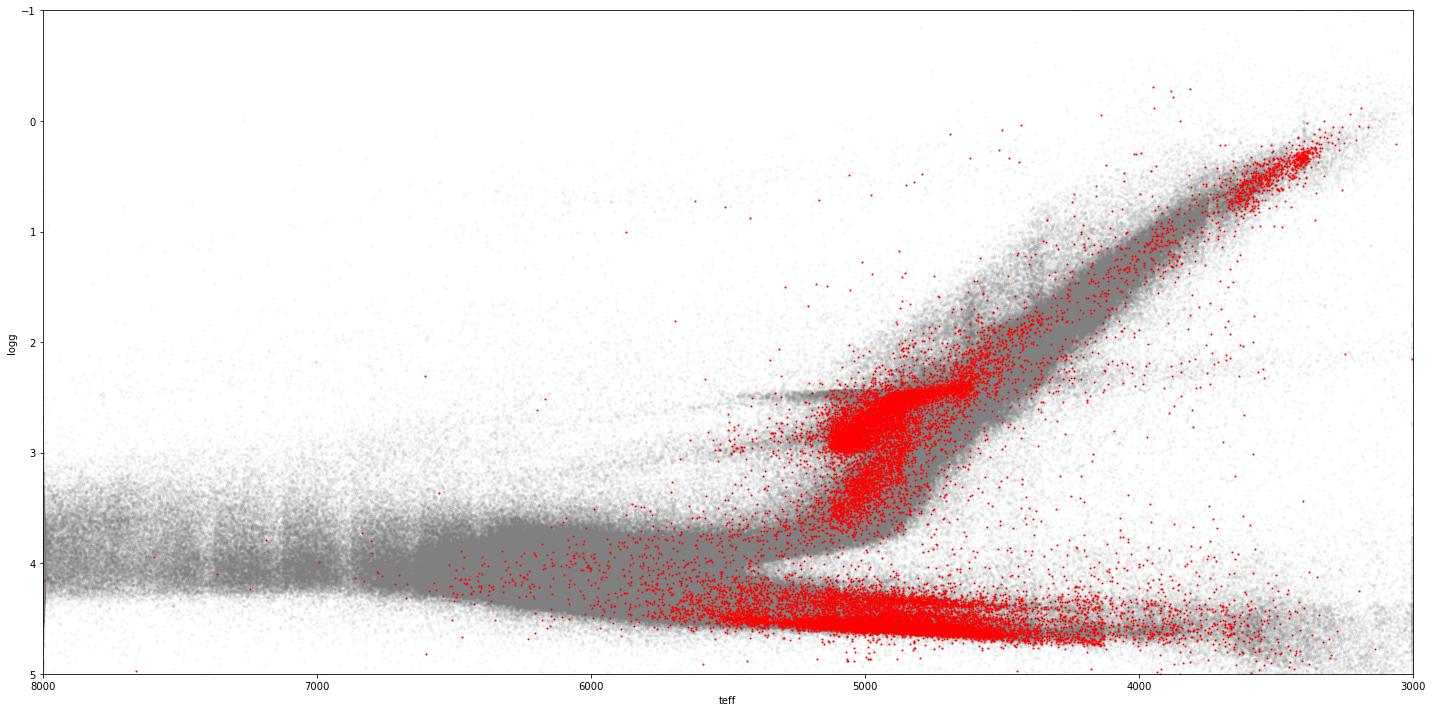

,sobject_id,cu_fe,eu_fe,ca_fe,y_fe,sc_fe,li_fe,sum
0,131216001101002,0,0,1,1,0,0,2
1,131216001101004,1,0,1,1,0,0,3
2,131216001101006,1,0,0,1,0,1,3
3,131216001101007,0,0,1,1,0,1,3
4,131216001101008,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1085515,230806004701393,0,0,0,0,0,0,0
1085516,230806004701394,1,0,0,0,0,1,2
1085517,230806004701395,0,0,1,0,0,0,1
1085518,230806004701396,1,1,1,0,0,0,3


In [507]:

# For each star, check if its cu_fe value is closer to the median value of the MS binaries or the median value of the non-MS binaries
med_cufe_binaries = GALAH_data['cu_fe'][ms_binary_selection].median()
med_cufe = GALAH_data['cu_fe'][~ms_binary_selection].median()


new_df = pd.DataFrame()
new_df['sobject_id'] = GALAH_data['sobject_id']


# Determine which median the 'cu_fe' value is closer to
# Converts the boolean to an integer
for element in elements:
    new_df[element] = (abs(GALAH_data[element] - GALAH_data[element][ms_binary_selection].median()) < 
                       abs(GALAH_data[element] - GALAH_data[element][~ms_binary_selection].median())).astype(int)

new_df['sum'] = new_df[elements].sum(axis=1)
new_df


# Get all rows from GALAH data where the sum of the element columns is 6
element_trends_stars = GALAH_data.loc[new_df[new_df['sum'] >= 5].index]

plt.figure(figsize=(20, 10))
plt.scatter(GALAH_data['teff'], GALAH_data['logg'], alpha=0.05, label='All', color='gray', s=5)
plt.scatter(element_trends_stars['teff'], element_trends_stars['logg'], alpha=1, label='Binary?', color='red', s=1)

plt.xlabel('teff')
plt.ylabel('logg' )
plt.ylim(-1, 5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlim(8000, 3000)
plt.tight_layout()
plt.show()

new_df

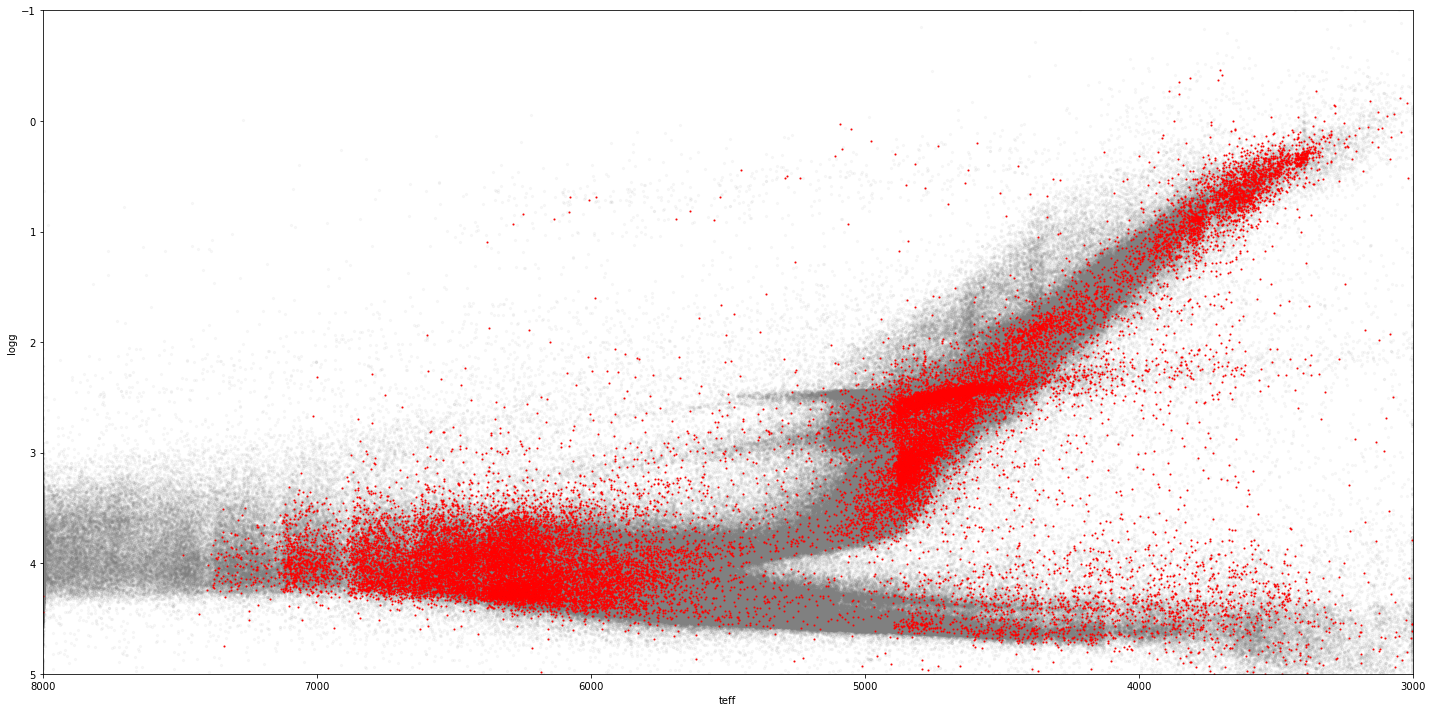

In [500]:

# For each star, check if its cu_fe value is closer to the median value of the MS binaries or the median value of the non-MS binaries
new_df = pd.DataFrame()
new_df['sobject_id'] = GALAH_data['sobject_id']


elements = ['cu_fe', 'eu_fe', 'ru_fe', 'ca_fe', 'y_fe', 'sc_fe', 'li_fe']
# Determine which median the 'cu_fe' value is closer to
# Converts the boolean to an integer
for element in elements:
    new_df[element] = (abs(GALAH_data[element] - GALAH_data[element][selection].median()) < 
                       abs(GALAH_data[element] - GALAH_data[element][~selection].median())).astype(int)

new_df['sum'] = new_df[elements].sum(axis=1)
new_df


# Get all rows from GALAH data where the sum of the element columns is > x
element_trends_stars = GALAH_data.loc[new_df[new_df['sum'] >= 5].index]

plt.figure(figsize=(20, 10))
plt.scatter(GALAH_data['teff'], GALAH_data['logg'], alpha=0.05, label='All', color='gray', s=5)
plt.scatter(element_trends_stars['teff'], element_trends_stars['logg'], alpha=1, label='Binary?', color='red', s=1)

plt.xlabel('teff')
plt.ylabel('logg' )
plt.ylim(-1, 5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlim(8000, 3000)
plt.tight_layout()
plt.show()